# Implementation, Analysis, Performance Evaluation and Comparison of Deep Convolutional Neural Networks for Image Classification

**Objective:** The objective of this assignment is to implement a deep convolutional neural network (CNN) for the identification of flower types. The provided dataset consists of five classes of flowers, namely chamomile, tulip, rose, sunflower, and dandelion. 

**Tasks:**
To complete this assignment, please submit a single notebook that includes the implementation and outputs of the following seven steps.
Provide answers for each sub-question by thorough analysis and extensive experimental investigation using the provided dataset. In other words, your answers should be backed by experimental analysis of your models and the dataset. Please ensure that the notebook retain the outputs. Failure to do so will result in zero marks for the corresponding steps in which no output is displayed.

**1. Prepare and Preprocess the data.**




In [1]:
import os

paths = []
labels = []

base_path = "/kaggle/input/flowers/flowers"

for flower_type in os.listdir(base_path):
    flower_type_path = os.path.join(base_path, flower_type)
    
    
    if os.path.isdir(flower_type_path):
        path_data = os.listdir(flower_type_path)
        paths.extend([os.path.join(flower_type_path, img) for img in path_data])
        labels.extend([flower_type] * len(path_data))

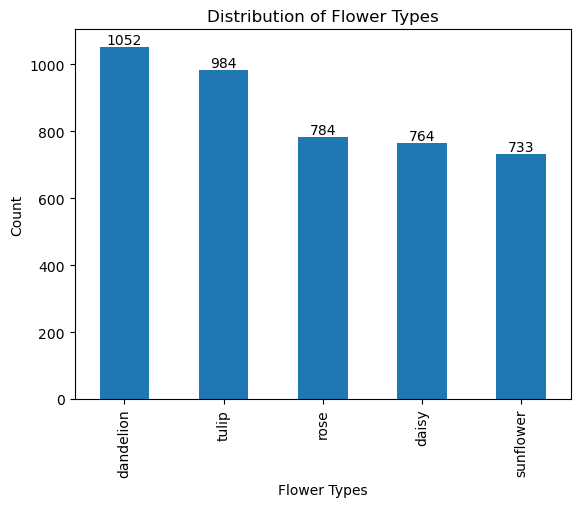

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.DataFrame({"path": paths, "label": labels})
label_counts = data['label'].value_counts()
ax = label_counts.plot(kind='bar', xlabel='Flower Types', ylabel='Count', title='Distribution of Flower Types')
for i, v in enumerate(label_counts):
    ax.text(i, v + 0.1, str(v), ha='center', va='bottom')

plt.show()


In [28]:
total_images = len(paths)
print(f'Total number of images: {total_images}')

Total number of images: 4317


In [31]:
import os
import shutil

for set_type in ['TRAIN', 'VAL', 'TEST']:
    for CLASS in os.listdir(base_path):
        class_path = os.path.join(base_path, set_type, CLASS.upper()) 
        if os.path.isdir(class_path):
            os.makedirs(class_path, exist_ok=True)

for CLASS in os.listdir(base_path):
    class_path = os.path.join(base_path, CLASS)

    if os.path.isdir(class_path):
        print(class_path + '     ' + CLASS)
        images = os.listdir(class_path)
        num_images = len(images)

        train_ratio = 0.7
        val_ratio = 0.2
        test_ratio = 0.1

        train_end = int(train_ratio * num_images)
        val_end = int((train_ratio + val_ratio) * num_images)

        for n, FILE_NAME in enumerate(images):
            img = os.path.join(class_path, FILE_NAME)

            if os.path.isfile(img):
                if n < train_end:
                    train_folder = os.path.join(base_path, 'TRAIN', CLASS.upper())
                    os.makedirs(train_folder, exist_ok=True)
                    shutil.copy(img, os.path.join(train_folder, FILE_NAME))
                elif n < val_end:
                    val_folder = os.path.join(base_path, 'VAL', CLASS.upper())
                    os.makedirs(val_folder, exist_ok=True)
                    shutil.copy(img, os.path.join(val_folder, FILE_NAME))
                else:
                    test_folder = os.path.join(base_path, 'TEST', CLASS.upper())
                    os.makedirs(test_folder, exist_ok=True)
                    shutil.copy(img, os.path.join(test_folder, FILE_NAME))


/Users/rathore/Downloads/flowers/daisy     daisy

/Users/rathore/Downloads/flowers/rose     rose

/Users/rathore/Downloads/flowers/tulip     tulip

/Users/rathore/Downloads/flowers/dandelion     dandelion

/Users/rathore/Downloads/flowers/sunflower     sunflower


In [30]:
from PIL import Image

def get_image_dimensions(image_path):
    with Image.open(image_path) as img:
        width, height = img.size
    return width, height

data['width'], data['height'] = zip(*data['path'].map(get_image_dimensions))

print(data[['label', 'width', 'height']])
mean_dimensions = data.groupby('label')[['width', 'height']].mean()
print(mean_dimensions)

          label  width  height

0         daisy    320     240

1         daisy    240     159

2         daisy    320     242

3         daisy    320     240

4         daisy    500     375

...         ...    ...     ...

4312  sunflower    320     216

4313  sunflower    320     200

4314  sunflower    240     217

4315  sunflower    320     241

4316  sunflower    240     221



[4317 rows x 3 columns]

                width      height

label                            

daisy      331.814136  252.619110

dandelion  346.769011  258.815589

rose       327.006378  244.187500

sunflower  348.354707  261.529332

tulip      336.140244  248.069106


In [2]:
def load_data(base_path, img_size=(224, 224,3)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(base_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(os.path.join(base_path, path)):
                if not file.startswith('.'):
                    img = cv2.imread(os.path.join(base_path, path, file))
                    img = cv2.resize(img, img_size)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {base_path} directory.')
    return X, y, labels

In [3]:
from tqdm import tqdm
import numpy as np
import cv2

TRAIN_DIR = '/kaggle/input/flowers/flowers/TRAIN'
TEST_DIR = '/kaggle/input/flowers/flowers/TEST'
VAL_DIR = '/kaggle/input/flowers/flowers/VAL'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 5/5 [00:26<00:00,  5.22s/it]


3019 images loaded from /kaggle/input/flowers/flowers/TRAIN directory.


100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


435 images loaded from /kaggle/input/flowers/flowers/TEST directory.


100%|██████████| 5/5 [00:07<00:00,  1.57s/it]

863 images loaded from /kaggle/input/flowers/flowers/VAL directory.


In [33]:
def plot_samples(X, y, labels_dict, n=50):
    
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 5
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Flowers: {}'.format(labels_dict[index]))
        plt.show()

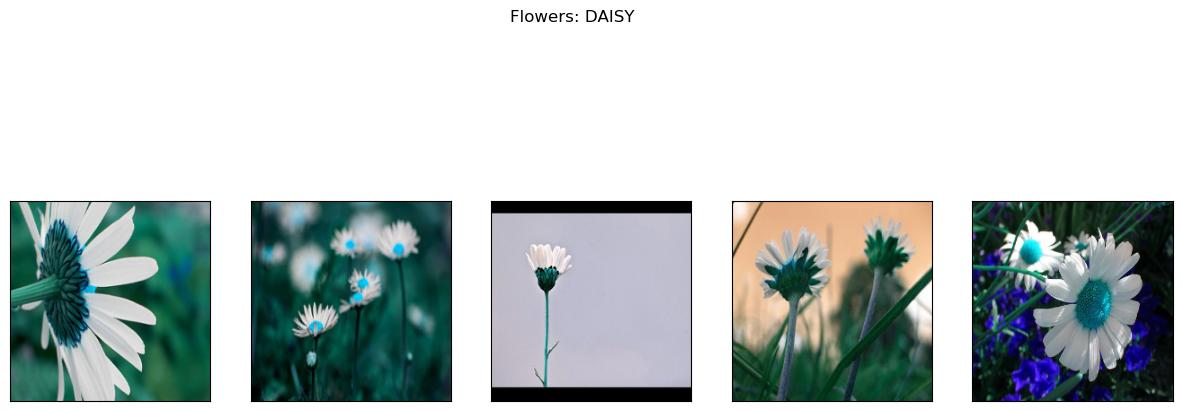

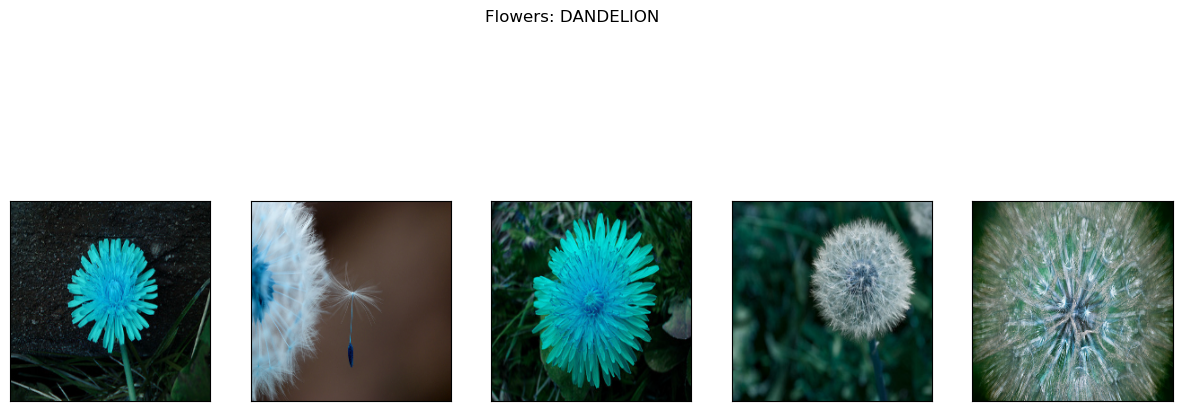

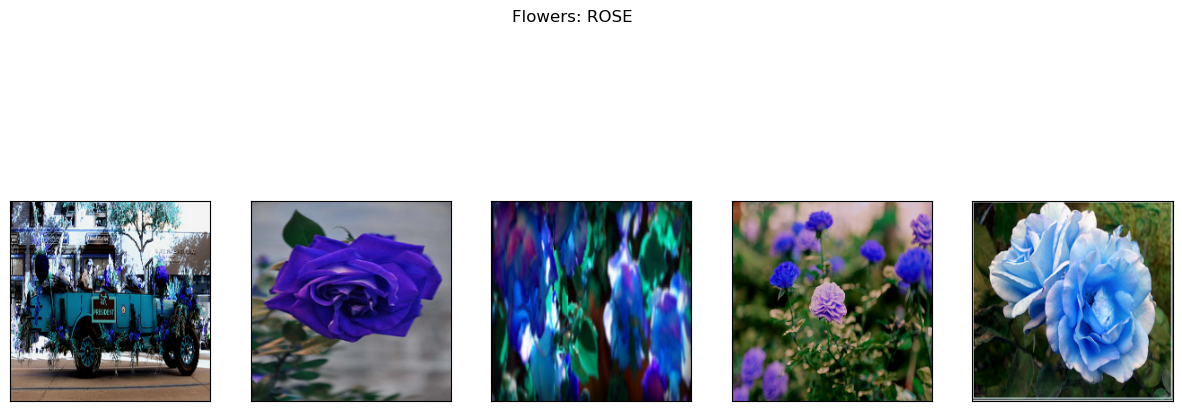

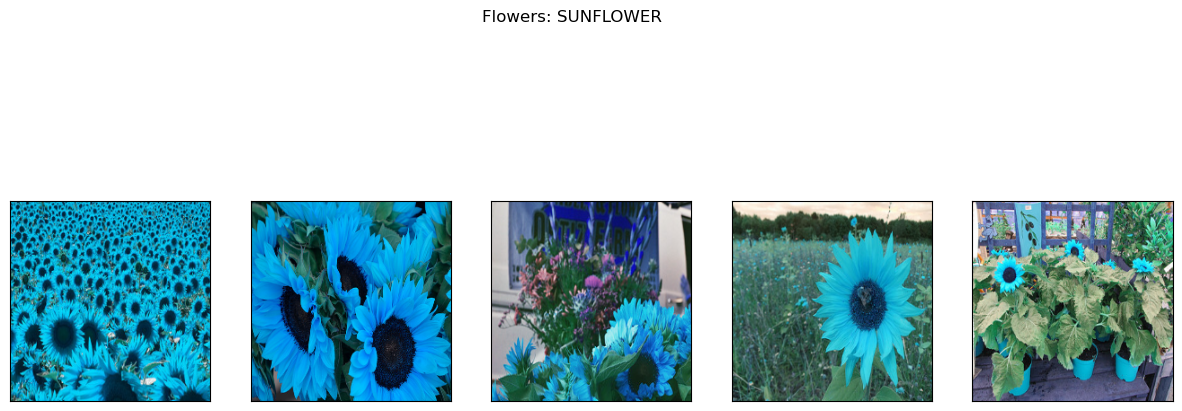

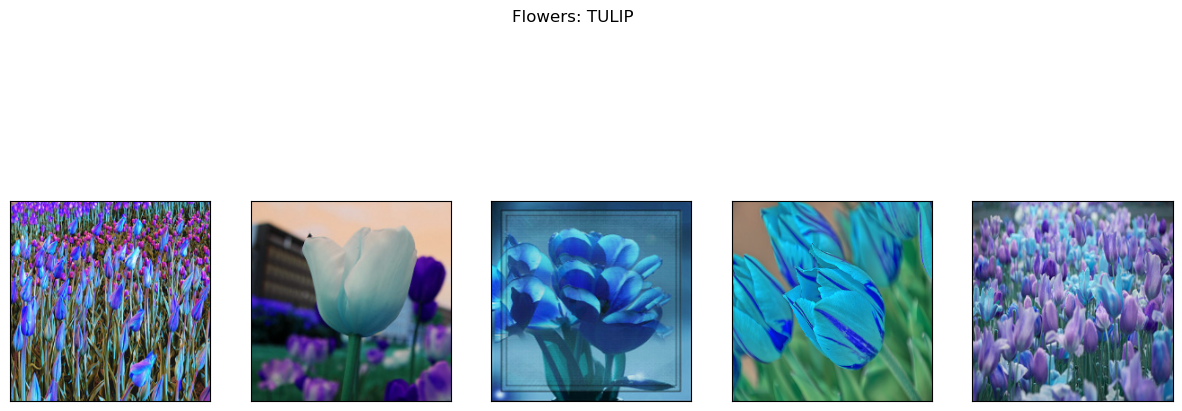

In [34]:
plot_samples(X_train, y_train, labels, 5)

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

target_size = (224, 224)
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical' 
)

val_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 3019 images belonging to 5 classes.
Found 863 images belonging to 5 classes.
Found 435 images belonging to 5 classes.



<img src='CNN.png' alt='given CNN'>

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import BayesianOptimization
from kerastuner import HyperParameters

# Define the model function
def build_model1(hp):
    model1 = Sequential()

    model1.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
    model1.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model1.add(MaxPooling2D(pool_size=(2, 2)))

    model1.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model1.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model1.add(MaxPooling2D(pool_size=(2, 2)))

    model1.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model1.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model1.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model1.add(MaxPooling2D(pool_size=(2, 2)))

    model1.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model1.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model1.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model1.add(MaxPooling2D(pool_size=(2, 2)))

    model1.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model1.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model1.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model1.add(MaxPooling2D(pool_size=(2, 2)))
    model1.add(Flatten())
    model1.add(Dense(4096, activation='relu'))
    model1.add(Dense(4096, activation='relu'))
    model1.add(Dense(5, activation='softmax'))
    
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-6, max_value=1e-2, sampling='log')
    hp_batch_size = hp.Int('batch_size', min_value=32, max_value=128, step=32)
    hp_optimizer = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop'])

    if hp_optimizer == 'adam':
        optimizer = Adam(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'sgd':
        optimizer = SGD(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=hp_learning_rate)

    model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model1

** Training the model.** 



In [37]:
tuner = BayesianOptimization(
    build_model1,
    objective='val_accuracy',
    max_trials=10,  
    directory='my_dir',
    project_name='my_project'
)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

tuner.search(train_generator, epochs=10, validation_data=val_generator, callbacks=[early_stopping])
best_trial = tuner.oracle.get_best_trials(1)[0]
best_hp = best_trial.hyperparameters.values
print(f"Best Hyperparameters: {best_hp}")
hp = HyperParameters()
hp.values = best_hp

best_optimizer = None
if hp['optimizer'] == 'adam':
    best_optimizer = Adam(learning_rate=hp['learning_rate'])
elif hp['optimizer'] == 'sgd':
    best_optimizer = SGD(learning_rate=hp['learning_rate'])
elif hp['optimizer'] == 'rmsprop':
    best_optimizer = RMSprop(learning_rate=hp['learning_rate'])

best_model = tuner.hypermodel.build(hp)
best_model.compile(optimizer=best_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = best_model.fit(train_generator, epochs=25, validation_data=val_generator, callbacks=[early_stopping])

Reloading Tuner from my_dir/my_project/tuner0.json

Best Hyperparameters: {'learning_rate': 1.6183555783356756e-05, 'batch_size': 32, 'optimizer': 'rmsprop'}


Epoch 1/25

95/95 [==============================] - 1608s 17s/step - loss: 1.6074 - accuracy: 0.2554 - val_loss: 1.6048 - val_accuracy: 0.3082

Epoch 2/25

95/95 [==============================] - 1618s 17s/step - loss: 1.5987 - accuracy: 0.2647 - val_loss: 1.5861 - val_accuracy: 0.3453

Epoch 3/25

95/95 [==============================] - 1592s 17s/step - loss: 1.5087 - accuracy: 0.3263 - val_loss: 1.6565 - val_accuracy: 0.3024

Epoch 4/25

95/95 [==============================] - 1646s 17s/step - loss: 1.3624 - accuracy: 0.4028 - val_loss: 1.2470 - val_accuracy: 0.4867

Epoch 5/25

95/95 [==============================] - 6728s 71s/step - loss: 1.2743 - accuracy: 0.4674 - val_loss: 1.2264 - val_accuracy: 0.5052

Epoch 6/25

95/95 [==============================] - 49795s 526s/step - loss: 1.2245 - accuracy: 0.4846 - val_loss: 1.1512 - val_accuracy: 0.5156

Epoch 7/25

95/95 [==============================] - 1536s 16s/step - loss: 1.1696 - accuracy: 0.5048 - val_loss: 1.2322 - val_a

In [60]:
test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

14/14 [==============================] - 45s 3s/step - loss: 0.9441 - accuracy: 0.6713

Test Accuracy: 67.13%


**Report the results. **




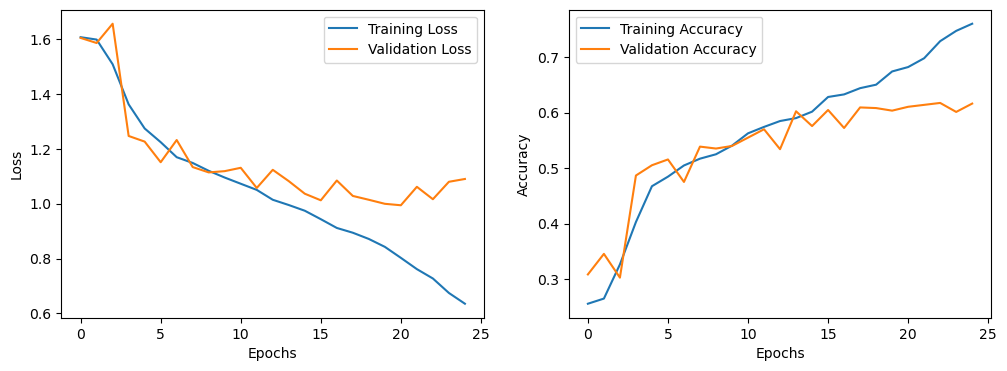

In [39]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [42]:
train_loss, train_accuracy = best_model.evaluate(train_generator)
print(f"Training Accuracy: {train_accuracy}")

val_loss, val_accuracy = best_model.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy}")

95/95 [==============================] - 405s 4s/step - loss: 0.5009 - accuracy: 0.8218

Training Accuracy: 0.8217952847480774

27/27 [==============================] - 121s 4s/step - loss: 1.0901 - accuracy: 0.6165

Validation Accuracy: 0.6164542436599731


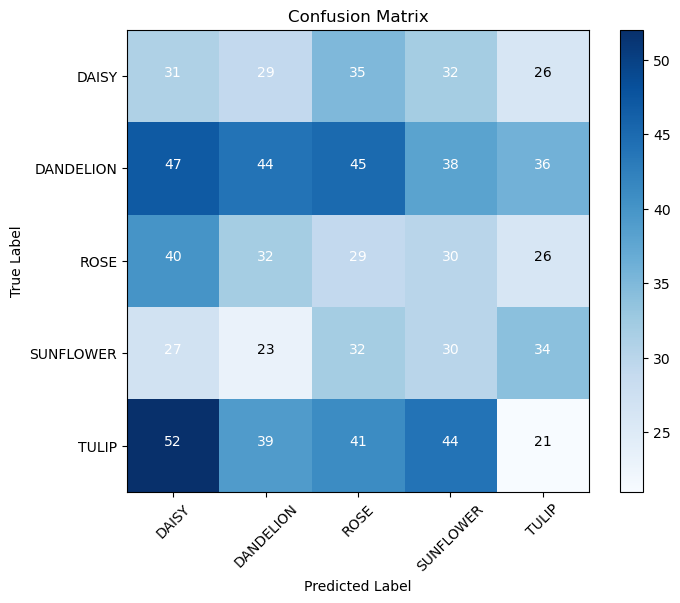

In [50]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt



class_names = list(val_generator.class_indices.keys())
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")

for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, str(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")
plt.show()

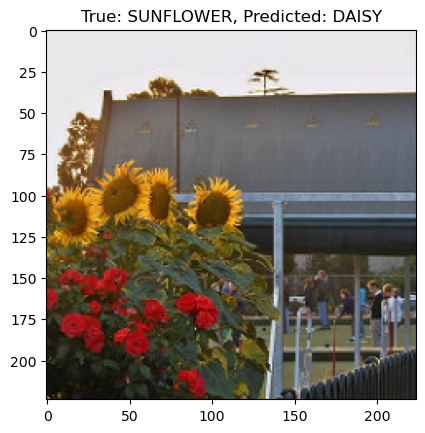

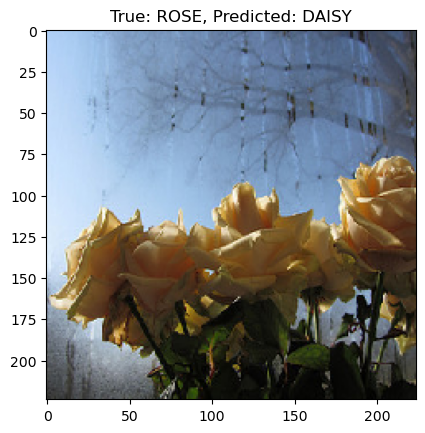

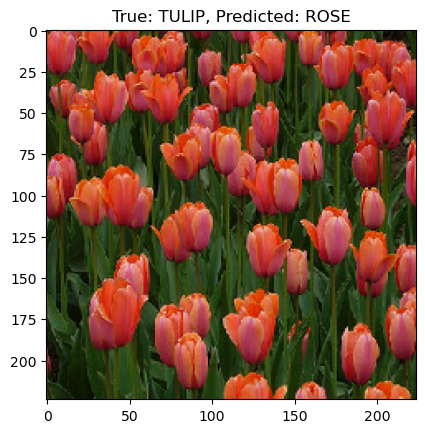

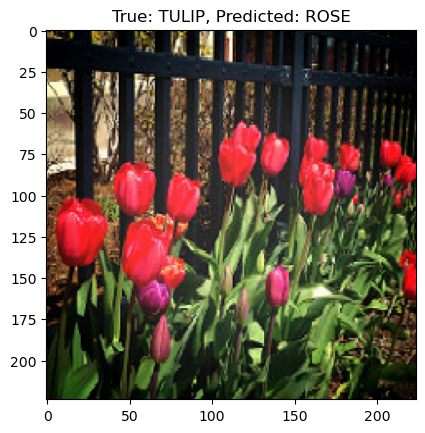

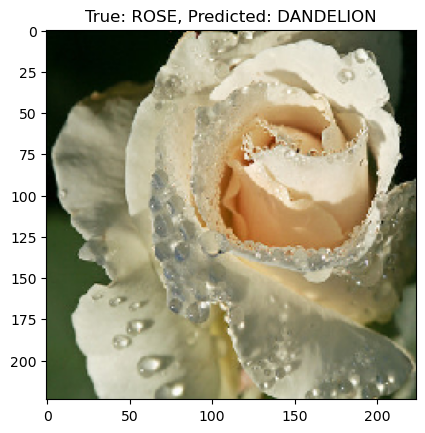

In [51]:
incorrect_predictions = np.where(predicted_labels != true_labels)[0]

for i in range(5):  
    index = np.random.choice(incorrect_predictions)
    img_path = val_generator.filepaths[index]

    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img)
    
    true_class = list(val_generator.class_indices.keys())[true_labels[index]]
    predicted_class = list(val_generator.class_indices.keys())[predicted_labels[index]]
    
    plt.title(f"True: {true_class}, Predicted: {predicted_class}")
    plt.show()

In [56]:
best_model.summary()

Model: "sequential_15"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv2d_183 (Conv2D)         (None, 224, 224, 64)      1792      

                                                                 

 conv2d_184 (Conv2D)         (None, 224, 224, 64)      36928     

                                                                 

 max_pooling2d_70 (MaxPooli  (None, 112, 112, 64)      0         

 ng2D)                                                           

                                                                 

 conv2d_185 (Conv2D)         (None, 112, 112, 128)     73856     

                                                                 

 conv2d_186 (Conv2D)         (None, 112, 112, 128)     147584    

                                                                 

 max_pooling2d_71 (MaxPooli  (None, 56, 56, 128)       0         

 ng2D)                               

** Test the model by giving it a picture taken by your own phone camera.**




1/1 [==============================] - 0s 220ms/step


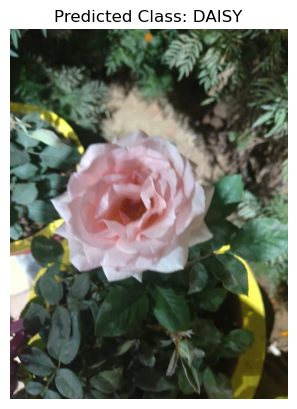

In [77]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
phone_img_path = "/Users/rathore/Downloads/WhatsApp Image 2023-11-08 at 6.47.44 PM.jpeg"
phone_img = cv2.imread(phone_img_path)
phone_img = cv2.resize(phone_img, (224, 224))
phone_img = phone_img / 255.0 

phone_img = np.expand_dims(phone_img, axis=0)

prediction = best_model.predict(phone_img)

predicted_class = np.argmax(prediction)

predicted_label = labels[predicted_class]

plt.imshow(cv2.cvtColor(cv2.imread(phone_img_path), cv2.COLOR_BGR2RGB))
plt.title(f"Predicted Class: {predicted_label}")
plt.axis('off')
plt.show()


** Use the same architecture but now train two different models one with L1 or L2 regularization, and one with batch normalization.**




In [60]:
def build_model_L1(hp):
    model_L1 = Sequential()

    model_L1.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3), kernel_regularizer=l1(0.01)))
    model_L1.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l1(0.01)))
    model_L1.add(MaxPooling2D(pool_size=(2, 2)))

    model_L1.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l1(0.01)))
    model_L1.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l1(0.01)))
    model_L1.add(MaxPooling2D(pool_size=(2, 2)))

    model_L1.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l1(0.01)))
    model_L1.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l1(0.01)))
    model_L1.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l1(0.01)))
    model_L1.add(MaxPooling2D(pool_size=(2, 2)))

    model_L1.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l1(0.01)))
    model_L1.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l1(0.01)))
    model_L1.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l1(0.01)))
    model_L1.add(MaxPooling2D(pool_size=(2, 2)))

    model_L1.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l1(0.01)))
    model_L1.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l1(0.01)))
    model_L1.add(Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l1(0.01)))
    model_L1.add(MaxPooling2D(pool_size=(2, 2)))
    
    model_L1.add(Flatten())
    model_L1.add(Dense(4096, activation='relu', kernel_regularizer=l1(0.01)))
    model_L1.add(Dense(4096, activation='relu', kernel_regularizer=l1(0.01)))
    model_L1.add(Dense(5, activation='softmax'))
    
    hp_learning_rate = 1.6183555783356756e-05
    hp_batch_size = 32
    hp_optimizer = 'rmsprop'

    if hp_optimizer == 'adam':
        optimizer = Adam(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'sgd':
        optimizer = SGD(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=hp_learning_rate)

    model_L1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model_L1


best_model1 = build_model_L1(None)  
history_L1 = best_model1.fit(train_generator, epochs=25, validation_data=val_generator, callbacks=[early_stopping])


Epoch 1/25

95/95 [==============================] - 1537s 16s/step - loss: 10505.5117 - accuracy: 0.2425 - val_loss: 9524.5811 - val_accuracy: 0.2433

Epoch 2/25

95/95 [==============================] - 1615s 17s/step - loss: 8640.2012 - accuracy: 0.2438 - val_loss: 7776.6309 - val_accuracy: 0.2433

Epoch 3/25

95/95 [==============================] - 1735s 18s/step - loss: 6993.0010 - accuracy: 0.2438 - val_loss: 6225.4995 - val_accuracy: 0.2433

Epoch 4/25

95/95 [==============================] - 1888s 20s/step - loss: 5541.9204 - accuracy: 0.2438 - val_loss: 4871.1147 - val_accuracy: 0.2433

Epoch 5/25

95/95 [==============================] - 1781s 19s/step - loss: 4282.5640 - accuracy: 0.2438 - val_loss: 3713.4897 - val_accuracy: 0.2433

Epoch 6/25

95/95 [==============================] - 1703s 18s/step - loss: 3218.4570 - accuracy: 0.2438 - val_loss: 2752.6526 - val_accuracy: 0.2433

Epoch 7/25

95/95 [==============================] - 36015s 383s/step - loss: 2357.5049 - acc

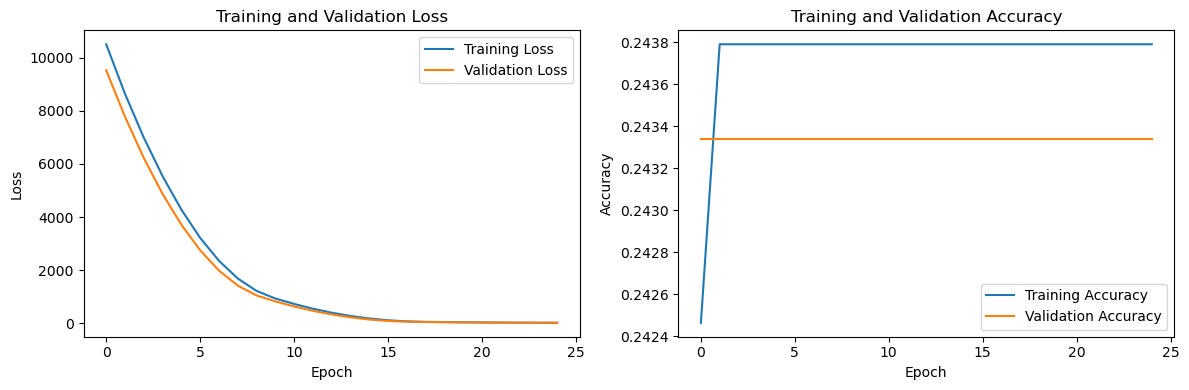

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_L1.history['loss'], label='Training Loss')
plt.plot(history_L1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training accuracy vs. validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history_L1.history['accuracy'], label='Training Accuracy')
plt.plot(history_L1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import BayesianOptimization

# Define the model function
def build_model_batch_norm(hp):
    model_batch_norm = Sequential()

    model_batch_norm.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
    model_batch_norm.add(BatchNormalization())
    model_batch_norm.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model_batch_norm.add(BatchNormalization())
    model_batch_norm.add(MaxPooling2D(pool_size=(2, 2)))

    model_batch_norm.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model_batch_norm.add(BatchNormalization())
    model_batch_norm.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model_batch_norm.add(BatchNormalization())
    model_batch_norm.add(MaxPooling2D(pool_size=(2, 2)))

    model_batch_norm.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model_batch_norm.add(BatchNormalization())
    model_batch_norm.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model_batch_norm.add(BatchNormalization())
    model_batch_norm.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model_batch_norm.add(BatchNormalization())
    model_batch_norm.add(MaxPooling2D(pool_size=(2, 2)))

    model_batch_norm.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model_batch_norm.add(BatchNormalization())
    model_batch_norm.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model_batch_norm.add(BatchNormalization())
    model_batch_norm.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model_batch_norm.add(BatchNormalization())
    model_batch_norm.add(MaxPooling2D(pool_size=(2, 2)))

    model_batch_norm.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model_batch_norm.add(BatchNormalization())
    model_batch_norm.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model_batch_norm.add(BatchNormalization())
    model_batch_norm.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model_batch_norm.add(BatchNormalization())
    model_batch_norm.add(MaxPooling2D(pool_size=(2, 2)))
    
    model_batch_norm.add(Flatten())
    model_batch_norm.add(Dense(4096, activation='relu'))
    model_batch_norm.add(BatchNormalization())
    model_batch_norm.add(Dense(4096, activation='relu'))
    model_batch_norm.add(BatchNormalization())
    model_batch_norm.add(Dense(5, activation='softmax'))
    
    hp_learning_rate = 1.6183555783356756e-05
    hp_batch_size = 32
    hp_optimizer = 'rmsprop'

    if hp_optimizer == 'adam':
        optimizer = Adam(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'sgd':
        optimizer = SGD(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=hp_learning_rate)

    model_batch_norm.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model_batch_norm


best_model_batch_norm = build_model_batch_norm(None)  
history_batch_norm = best_model_batch_norm.fit(train_generator, epochs=25, validation_data=val_generator, callbacks=[early_stopping])


Epoch 1/25

95/95 [==============================] - 1929s 20s/step - loss: 1.4984 - accuracy: 0.4770 - val_loss: 2.6555 - val_accuracy: 0.2433

Epoch 2/25

95/95 [==============================] - 3034s 32s/step - loss: 0.7006 - accuracy: 0.7449 - val_loss: 4.9539 - val_accuracy: 0.2433

Epoch 3/25

95/95 [==============================] - 2127s 22s/step - loss: 0.4296 - accuracy: 0.8503 - val_loss: 7.1999 - val_accuracy: 0.2433

Epoch 4/25

95/95 [==============================] - 2207s 23s/step - loss: 0.3056 - accuracy: 0.8963 - val_loss: 5.4250 - val_accuracy: 0.2457

Epoch 5/25

95/95 [==============================] - 16003s 170s/step - loss: 0.2677 - accuracy: 0.9092 - val_loss: 2.9035 - val_accuracy: 0.3581

Epoch 6/25

95/95 [==============================] - 45800s 487s/step - loss: 0.1866 - accuracy: 0.9384 - val_loss: 2.0389 - val_accuracy: 0.5006

Epoch 7/25

95/95 [==============================] - 2271s 24s/step - loss: 0.1595 - accuracy: 0.9467 - val_loss: 1.5794 - val

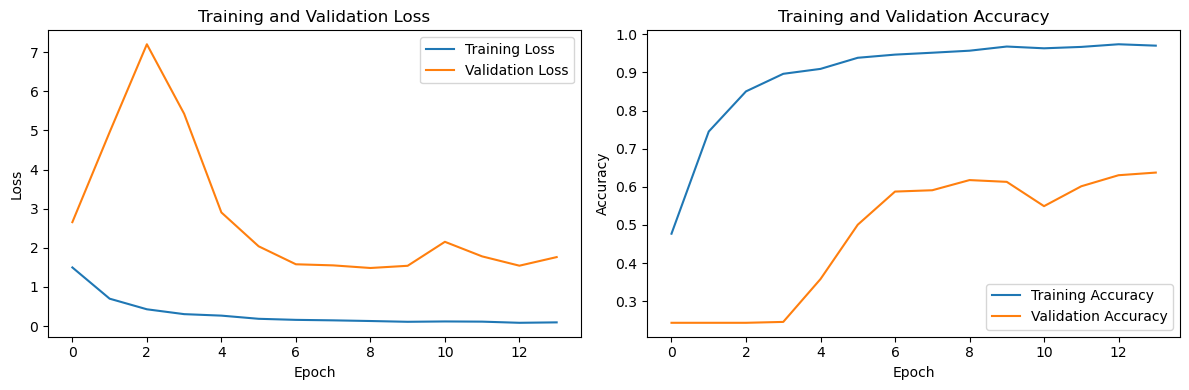

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_batch_norm.history['loss'], label='Training Loss')
plt.plot(history_batch_norm.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training accuracy vs. validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history_batch_norm.history['accuracy'], label='Training Accuracy')
plt.plot(history_batch_norm.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**Improve the accuracy by trying something extra. ** 





In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from kerastuner.tuners import BayesianOptimization
from kerastuner import HyperParameters

# Create ImageDataGenerators with data augmentation
train_datagen1 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen1 = ImageDataGenerator(rescale=1./255)
batch_size = 32
target_size = (224,224)

# Flow data from directories
train_generator1 = train_datagen1.flow_from_directory(
    TRAIN_DIR,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical' 
)

val_generator1 = test_datagen1.flow_from_directory(
    VAL_DIR,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator1 = test_datagen1.flow_from_directory(
    TEST_DIR,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Define the model function with reduced filter sizes and dropout
def build_model4(hp):
    model4 = Sequential()

    model4.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
    model4.add(BatchNormalization())
    model4.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model4.add(BatchNormalization())
    model4.add(MaxPooling2D(pool_size=(2, 2)))
    model4.add(Dropout(0.25))  
    model4.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model4.add(BatchNormalization())
    model4.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model4.add(BatchNormalization())
    model4.add(MaxPooling2D(pool_size=(2, 2)))
    model4.add(Dropout(0.25))

    model4.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model4.add(BatchNormalization())
    model4.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model4.add(BatchNormalization())
    model4.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model4.add(BatchNormalization())
    model4.add(MaxPooling2D(pool_size=(2, 2)))
    model4.add(Dropout(0.25))

    model4.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model4.add(BatchNormalization())
    model4.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model4.add(BatchNormalization())
    model4.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model4.add(BatchNormalization())
    model4.add(MaxPooling2D(pool_size=(2, 2)))
    model4.add(Dropout(0.25))

    model4.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model4.add(BatchNormalization())
    model4.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model4.add(BatchNormalization())
    model4.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model4.add(BatchNormalization())
    model4.add(MaxPooling2D(pool_size=(2, 2)))
    model4.add(Dropout(0.25))

    model4.add(Flatten())
    model4.add(Dense(4096, activation='relu'))
    model4.add(BatchNormalization())
    model4.add(Dropout(0.5))
    model4.add(Dense(4096, activation='relu'))
    model4.add(BatchNormalization())
    model4.add(Dropout(0.5))
    model4.add(Dense(5, activation='softmax'))
    
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-6, max_value=1e-2, sampling='log')
    hp_batch_size = hp.Int('batch_size', min_value=32, max_value=128, step=32)
    hp_optimizer = hp.Choice('optimizer', values=['adam','sgd', 'rmsprop'])

    if hp_optimizer == 'adam':
        optimizer = Adam(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'sgd':
        optimizer = SGD(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=hp_learning_rate)

    model4.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model4

Found 3019 images belonging to 5 classes.
Found 863 images belonging to 5 classes.
Found 435 images belonging to 5 classes.


In [12]:
from kerastuner.tuners import BayesianOptimization
from kerastuner import HyperParameters
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow_addons.optimizers import AdamW

# Define your data generators
train_datagen1 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen1 = ImageDataGenerator(rescale=1./255)
batch_size = 64
target_size = (224, 224)

# Flow data from directories
train_generator1 = train_datagen1.flow_from_directory(
    TRAIN_DIR,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator1 = test_datagen1.flow_from_directory(
    VAL_DIR,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

tuner = BayesianOptimization(
    build_model4,
    objective='val_accuracy',
    max_trials=10,  
    directory='my_dir',
    project_name='my_project1'
)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

tuner.search(train_generator1, epochs=10, validation_data=val_generator1, callbacks=[early_stopping])
best_trial = tuner.oracle.get_best_trials(1)[0]
best_hp = best_trial.hyperparameters.values
print(f"Best Hyperparameters: {best_hp}")
hp = HyperParameters()
hp.values = best_hp

best_optimizer = None
if hp['optimizer'] == 'adam':
    best_optimizer = Adam(learning_rate=hp['learning_rate'])
elif hp['optimizer'] == 'sgd':
    best_optimizer = SGD(learning_rate=hp['learning_rate'])
elif hp['optimizer'] == 'rmsprop':
    best_optimizer = RMSprop(learning_rate=hp['learning_rate'])

best_model1 = tuner.hypermodel.build(hp)
best_model1.compile(optimizer=best_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history4 = best_model1.fit(train_generator1, epochs=25, validation_data=val_generator1, callbacks=[early_stopping])


Found 3019 images belonging to 5 classes.
Found 863 images belonging to 5 classes.
Best Hyperparameters: {'learning_rate': 0.0008701647078388132, 'batch_size': 128, 'optimizer': 'rmsprop'}
Epoch 1/25


2023-11-23 13:32:54.763555: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_28/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


48/48 [==============================] - 54s 969ms/step - loss: 4.1052 - accuracy: 0.3018 - val_loss: 14.4731 - val_accuracy: 0.2236
Epoch 2/25
48/48 [==============================] - 43s 881ms/step - loss: 2.7420 - accuracy: 0.2816 - val_loss: 312.5068 - val_accuracy: 0.2260
Epoch 3/25
48/48 [==============================] - 43s 887ms/step - loss: 2.1906 - accuracy: 0.3624 - val_loss: 8.7889 - val_accuracy: 0.3279
Epoch 4/25
48/48 [==============================] - 44s 901ms/step - loss: 2.2562 - accuracy: 0.3306 - val_loss: 50.0767 - val_accuracy: 0.1819
Epoch 5/25
48/48 [==============================] - 43s 894ms/step - loss: 1.9587 - accuracy: 0.3647 - val_loss: 4.2901 - val_accuracy: 0.2769
Epoch 6/25
48/48 [==============================] - 44s 909ms/step - loss: 1.8307 - accuracy: 0.3663 - val_loss: 2.2619 - val_accuracy: 0.2839
Epoch 7/25
48/48 [==============================] - 45s 920ms/step - loss: 1.9600 - accuracy: 0.3498 - val_loss: 3.0257 - val_accuracy: 0.3140
Epoch 

In [14]:
train_loss, train_accuracy = best_model1.evaluate(train_generator1)
print(f"Training Accuracy: {train_accuracy}")

val_loss, val_accuracy = best_model1.evaluate(val_generator1)
print(f"Validation Accuracy: {val_accuracy}")

95/95 [==============================] - 38s 373ms/step - loss: 1.7827 - accuracy: 0.5197
Training Accuracy: 0.519708514213562
27/27 [==============================] - 3s 91ms/step - loss: 1.5434 - accuracy: 0.4994
Validation Accuracy: 0.4994206130504608


In [17]:
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=target_size,
    batch_size=64,
    class_mode='categorical'
)

Found 435 images belonging to 5 classes.


In [18]:
test_loss, test_accuracy = best_model1.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

7/7 [==============================] - 6s 950ms/step - loss: 1.3748 - accuracy: 0.5632
Test Accuracy: 56.32%


In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, AveragePooling2D, Dense, Add, Flatten
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import BayesianOptimization
from kerastuner import HyperParameters

def identity_block(x, filters):
    filters1, filters2, filters3 = filters

    x_shortcut = x

    x = Conv2D(filters1, (1, 1), padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), padding='valid')(x)
    x = BatchNormalization()(x)

    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)

    return x

def convolutional_block(x, filters, strides):
    filters1, filters2, filters3 = filters

    x_shortcut = x

    x = Conv2D(filters1, (1, 1), strides=strides, padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), padding='valid')(x)
    x = BatchNormalization()(x)

    x_shortcut = Conv2D(filters3, (1, 1), strides=strides, padding='valid')(x_shortcut)
    x_shortcut = BatchNormalization()(x_shortcut)

    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)

    return x

def build_resnet_with_tuning(hp):
    input_tensor = Input(shape=(224, 224, 3))
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = convolutional_block(x, filters=[64, 64, 256], strides=(1, 1))
    x = identity_block(x, filters=[64, 64, 256])
    x = identity_block(x, filters=[64, 64, 256])

    x = convolutional_block(x, filters=[128, 128, 512], strides=(2, 2))
    x = identity_block(x, filters=[128, 128, 512])
    x = identity_block(x, filters=[128, 128, 512])
    x = identity_block(x, filters=[128, 128, 512])

    x = convolutional_block(x, filters=[256, 256, 1024], strides=(2, 2))
    x = identity_block(x, filters=[256, 256, 1024])
    x = identity_block(x, filters=[256, 256, 1024])
    x = identity_block(x, filters=[256, 256, 1024])
    x = identity_block(x, filters=[256, 256, 1024])
    x = identity_block(x, filters=[256, 256, 1024])

    x = convolutional_block(x, filters=[512, 512, 2048], strides=(2, 2))
    x = identity_block(x, filters=[512, 512, 2048])
    x = identity_block(x, filters=[512, 512, 2048])

    x = AveragePooling2D((2, 2))(x)
    x = Flatten()(x)

    # Dense layers with hyperparameter tuning
    for _ in range(hp['num_dense_layers']):
        x = Dense(hp['dense_units'], activation='relu')(x)
    output = Dense(5, activation='softmax')(x)

    model5 = Model(inputs=input_tensor, outputs=output)

    hp_resnet = HyperParameters()

    # Hyperparameter for choosing optimizer
    optimizer_choice = hp_resnet.Choice('optimizer', values=['adam', 'sgd', 'rmsprop'])
    hp_learning_rate = hp_resnet.Float('learning_rate', min_value=1e-6, max_value=1e-2, sampling='log')

    # Use the new HyperParameters instance for hyperparameter tuning
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=hp_learning_rate)
    elif optimizer_choice == 'sgd':
        optimizer = SGD(learning_rate=hp_learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop(learning_rate=hp_learning_rate)


    model5.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model5

# Create BayesianOptimization tuner
tuner = BayesianOptimization(
    build_resnet_with_tuning,
    objective='val_accuracy',
    max_trials=10,
    directory='my_dir',
    project_name='resnet_tuning'
)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Start the search for the best hyperparameters
tuner.search(train_generator, epochs=10, validation_data=val_generator, callbacks=[early_stopping])

# Get the best hyperparameters
best_trial = tuner.oracle.get_best_trials(1)[0]
best_hp = best_trial.hyperparameters.values
print(f"Best Hyperparameters: {best_hp}")

# Build and compile the best ResNet model
best_resnet_model = tuner.hypermodel.build(best_hp)
best_resnet_model.compile(optimizer=Adam(learning_rate=best_hp['learning_rate']), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the best model
history5 = best_resnet_model.fit(train_generator, epochs=25, validation_data=val_generator, callbacks=[early_stopping])

Best Hyperparameters: {'num_dense_layers': 3, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.00036536789728141406}
Epoch 1/25
95/95 [==============================] - 57s 217ms/step - loss: 1.7079 - accuracy: 0.3531 - val_loss: 1.9101 - val_accuracy: 0.2433
Epoch 2/25
95/95 [==============================] - 19s 204ms/step - loss: 1.1619 - accuracy: 0.5406 - val_loss: 2.8982 - val_accuracy: 0.2433
Epoch 3/25
95/95 [==============================] - 20s 205ms/step - loss: 1.0610 - accuracy: 0.5863 - val_loss: 2.6517 - val_accuracy: 0.2433
Epoch 4/25
95/95 [==============================] - 20s 207ms/step - loss: 0.9773 - accuracy: 0.6274 - val_loss: 2.1350 - val_accuracy: 0.3001
Epoch 5/25
95/95 [==============================] - 19s 204ms/step - loss: 0.9315 - accuracy: 0.6366 - val_loss: 1.6952 - val_accuracy: 0.5006
Epoch 6/25
95/95 [==============================] - 19s 204ms/step - loss: 0.8316 - accuracy: 0.6966 - val_loss: 1.9114 - val_accuracy: 0.4739
Epoch 7/25


In [12]:
test_loss, test_accuracy = best_resnet_model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

14/14 [==============================] - 2s 161ms/step - loss: 1.1723 - accuracy: 0.6828
Test Accuracy: 68.28%


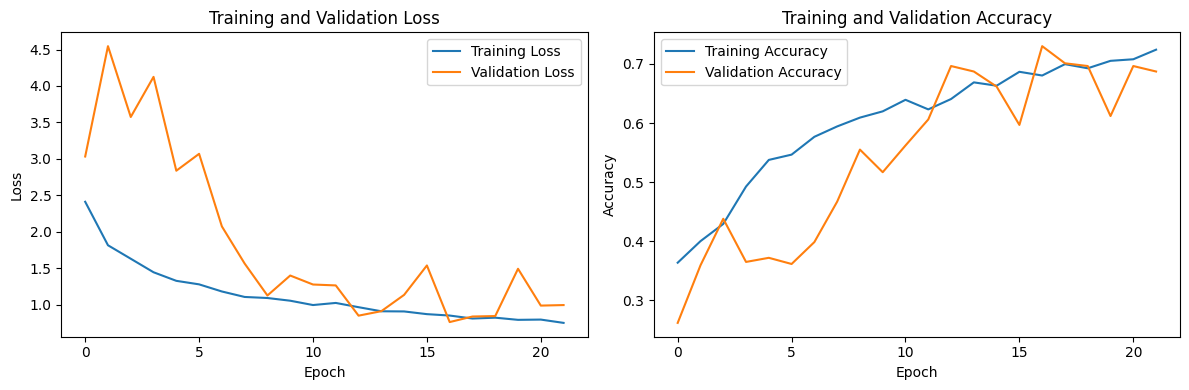

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history5.history['loss'], label='Training Loss')
plt.plot(history5.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training accuracy vs. validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history5.history['accuracy'], label='Training Accuracy')
plt.plot(history5.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [6]:
pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [20]:
import tensorflow as tf
import tensorflow.keras.layers as L
import efficientnet.tfkeras as efn

NUM_CLASSES = 5

efficientnet = tf.keras.Sequential([
    efn.EfficientNetB2(
        input_shape=(150, 150, 3),
        weights='imagenet',
        include_top=False
    ),
    L.GlobalMaxPooling2D(),
    L.Dropout(rate=0.25),
    L.Dense(NUM_CLASSES, activation='sigmoid')
    ])
        
efficientnet.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)
    
efficientnet.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b2 (Functiona  (None, 5, 5, 1408)        7768562   
 l)                                                              
                                                                 
 global_max_pooling2d_2 (Gl  (None, 1408)              0         
 obalMaxPooling2D)                                               
                                                                 
 dropout_9 (Dropout)         (None, 1408)              0         
                                                                 
 dense_5 (Dense)             (None, 5)                 7045      
                                                                 
Total params: 7775607 (29.66 MB)
Trainable params: 7708039 (29.40 MB)
Non-trainable params: 67568 (263.94 KB)
_________________________________________________________________


In [21]:
import time
import pickle

start = time.time()

efficientnet_history = efficientnet.fit_generator(
    train_generator1,
    epochs=25,
    validation_data=val_generator1
)

end = time.time()
print(end - start)
history_filename = 'efficientnet_history.pkl'

with open(history_filename, 'wb') as file:
    pickle.dump(efficientnet_history.history, file)

/tmp/ipykernel_47/1715927879.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  efficientnet_history = efficientnet.fit_generator(


Epoch 1/25


2023-11-22 15:19:34.868824: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/efficientnet-b2/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


48/48 [==============================] - 102s 1s/step - loss: 0.3907 - accuracy: 0.7658 - val_loss: 0.2189 - val_accuracy: 0.8667
Epoch 2/25
48/48 [==============================] - 50s 1s/step - loss: 0.1033 - accuracy: 0.9162 - val_loss: 0.1261 - val_accuracy: 0.9143
Epoch 3/25
48/48 [==============================] - 50s 1s/step - loss: 0.0675 - accuracy: 0.9424 - val_loss: 0.1334 - val_accuracy: 0.9085
Epoch 4/25
48/48 [==============================] - 49s 1s/step - loss: 0.0561 - accuracy: 0.9569 - val_loss: 0.1122 - val_accuracy: 0.9235
Epoch 5/25
48/48 [==============================] - 50s 1s/step - loss: 0.0393 - accuracy: 0.9718 - val_loss: 0.1181 - val_accuracy: 0.9200
Epoch 6/25
48/48 [==============================] - 50s 1s/step - loss: 0.0305 - accuracy: 0.9748 - val_loss: 0.0912 - val_accuracy: 0.9386
Epoch 7/25
48/48 [==============================] - 51s 1s/step - loss: 0.0440 - accuracy: 0.9659 - val_loss: 0.1966 - val_accuracy: 0.8795
Epoch 8/25
48/48 [============

In [22]:
test_loss, test_accuracy = efficientnet.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

7/7 [==============================] - 2s 250ms/step - loss: 0.0961 - accuracy: 0.9264
Test Accuracy: 92.64%
